In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
#from iri2016 import timeprofile, timeprofile2
from model_utils import *
from scipy import stats
from julia_utils_v3 import *


In [2]:
def GetArrays_v0(directory, filename, PlotFlag):
    hour_i= 18.0
    hour_f = 7.0
    h_min = 90.0
    h_max = 1008.75
    delta_ran = 3.75

    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/2D Parameters/gdalt']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1']
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    timestamps = hf['Data/Array Layout/']['timestamps']
    vvert = hf['Data/Table Layout/']['vipn1']
    time_vector = []
    v_zonal = np.array(vipe1).T
    v_vertical = np.array(vipn1).T
    snl2 = np.array(snl2).T
    print("v_zonal.shape",v_zonal.shape)
    print("v_vertical.shape",v_vertical.shape)
    print("snl2.shape",snl2.shape)
    #snl = np.array(snl2).flatten()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    rango = np.array(rango)
    range_diff = np.diff(rango)
    #delta_range = range_diff[0]
    #array = np.array([1,2,3,4,4,5])
    mode = stats.mode(range_diff)
    print('delta_range', mode[0])
    delta_range = mode[0]
    #print('delta range: ', delta_range)#valor constante para todo el arreglo
    MinRange, MaxRange = 90.0,1008.75 #np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
#range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
    DataMatrixVert = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
    DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    prev_stamps = []
       #################################
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    year = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    time_range, range_fixed = GetTimeRangeArrays(year, month, day, hour_i, hour_f,h_min,h_max,delta_ran)

    dir_plots = 'Plots-%s-%d' % (mes, anio)
    dir_plots_EEJ = 'Plots-%s-%d/EEJ' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    #for k in range(len(rango)):
    #    row = RowInMatrix[k]
        # Putting snr in corresponding matrix element
    #    DataMatrix[row,col] = snl[k]
    #    DataMatrixVert[row,col] = vvert[k]
    #    if row<PastRow:
    #        col += 1
    #    PastRow = row
    data = snl2#DataMatrix.T#[::-1]
    dataVert = v_vertical#DataMatrixVert.T
    #line.split()[0]
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 18)
    print("Time string: ", string_t0)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    #dt0 = datetime_objects[0]
    #print(string_t0)
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=600),dtype=int)
    #print("Datetime_objs: ",datetime_objects )
    #print("dt0: ", dt0)
    #print(dt_indices)
    #print(rango2D.shape, snl2.shape, data.shape, datetime_objects.shape)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts]
    #time_Range_index = np.linspace(0,78,77)
    time_range_index = np.arange(0,78)
    print(time_range_index)

    ###############################################################################
    #d_prom = np.zeros((times_repeated.shape[0], data.shape[1]))
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):

        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
    #'''
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    #d_prom2 = np.copy(d_prom)
    #print("diff")
    #print(diff)
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan

    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
        b3[:,j]=b_aux

    #'''

    #timedelta(seconds=600)
    #print(time_range.shape, range_fixed.shape, d_prom.shape)
    #print(time_range[0],time_range[-1])
    if PlotFlag:
        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([170,900])
#dia = dia - 1
        fig_title = r'F-Dispersa - Promedio(%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        #plt.savefig('%s/promedio-%s.png' % (dir_plots,str_date))

        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(index), range_array, data.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([90,900])
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
#dia = dia - 1
        fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/ESF-not-avg-%s.png' % (dir_plots,str_date))

        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(index), range_array, data.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([80,160])
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
#dia = dia - 1
        fig_title = r'Electrochorro Ecuatorial (%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/EEJ-not-avg-%s.png' % (dir_plots_EEJ,str_date))
        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, dataVert.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([80,160])
        #fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day)
        #plt.title(fig_title, fontsize=15)
        #        str_date = '(%d-%02d-%02d)' % (year, month, day)
        # This simply sets the x-axis data to diagonal so it fits better.
        #fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'E$\times$B (m/s)', fontsize=17)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/Velocidad-vertical/vertical-velocity-%s.png' % (dir_plots,str_date))

    return time_range, range_fixed, b3,data,snl, snl2, index, range_array, rango, dir_plots, np.array(datetime_objects), dataVert
    ################################################################################


In [3]:
year = 2024
month = 1
day = 1
str_month = GetMonth(month)
plots_boletin = '/home/juanpablo/Desktop-JRO/Plots-Boletines/%02d/%s' % (year,str_month)
directory = 'hdf5-files-%s-%d/' % (str_month, year)
plot_format = 'pdf'
dir_plots = 'Plots-%s-%d' % (str_month,year)
dir_plots_EEJ = 'Plots-%s-%d/EEJ' % (str_month,year)
#filename ='jul%d%02d%02d_esf.001.hdf5' % (year,month,day)#'jro20191202a.001.hdf5'#'jro20200114b.001.hdf5'#'jro20200113a.001.hdf5'
filename ='jul%d%02d%02d_esf.hdf5' % (year,month,day)#'jro20191202a.001.hdf5'#'jro20200114b.001.hdf5'#'jro20200113a.001.hdf5'
#filename ='jul%d%02d%02d_esf.001.hdf5' % (year,month,day)
print(filename)
print('dir_plots = ', dir_plots)
#"jul20210903_esf.hdf5"

jul20240101_esf.hdf5
dir_plots =  Plots-Enero-2024


In [4]:
#filename = "jul20210903_esf.001.hdf5"
file_hf5 = directory + filename
hf = h5py.File(file_hf5, 'r')
with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipn
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipn
Data/Array Layout/Layout Description
Data/Array Layout/gdalt
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters
Metadata/Independent Spatial Parameters
Metadata/_record_layout


In [5]:
snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl'])
rango = hf['Data/Table Layout/']['gdalt']
timestamps = hf['Data/Array Layout/']['timestamps']
#vipe1 = hf['Data/Array Layout/2D Parameters/vipe1']
vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
#vipe1 = hf['Data/Array Layout/2D Parameters/vipe']
#vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
print(snl2.shape,snl2.shape[0]*snl2.shape[1] ,rango.shape,timestamps.shape)
#print(vipe1.shape, vipn1.shape)

(107, 7769) 831283 (93480,) (7769,)


In [6]:
#MinRange, MaxRange = 90.0,1008.75 #np.min(rango), ran_max#np.max(rango)
MinRange, MaxRange = np.min(rango), np.max(rango)

range_diff = np.diff(rango)
#delta_range = range_diff[0]
#array = np.array([1,2,3,4,4,5])
mode = stats.mode(range_diff)
print('delta_range', mode[0])
delta_range = mode[0]
snl = np.array(snl2).flatten()
DataMatrixRows = int((MaxRange-MinRange)/delta_range)
range_array = np.linspace(MinRange, MaxRange, DataMatrixRows)#+1)
#range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
DataMatrix = np.ones((DataMatrixRows, snl2.shape[1]))*np.nan
#DataMatrixVert = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
#DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
print(range_array.shape, DataMatrix.T.shape, RowInMatrix.shape)
print(min(rango), max(rango))

delta_range [3.]
(465,) (7769, 465) (93480,)
0.0 1395.0


In [7]:
col=0
PastRow = 0
for k in range(len(rango)):
    row = RowInMatrix[k]
    # Putting snr in corresponding matrix element
    DataMatrix[row,col] = snl[k]
    #DataMatrixVert[row,col] = vvert[k]
    if row<PastRow:
        col += 1
    PastRow = row
data = DataMatrix.T#[::-1]
prev_stamps = []

datetime_objects = []
for ts in timestamps:
    if ts in prev_stamps:
        print('Same timestap')
    else:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')


IndexError: index 465 is out of bounds for axis 0 with size 465

NameError: name 'datetime_objects' is not defined

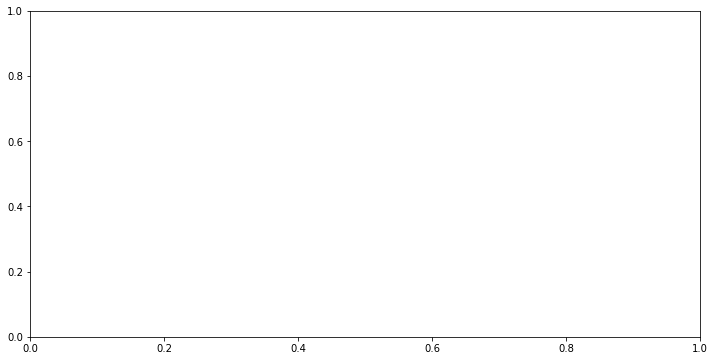

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, data.T,cmap='jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)


In [9]:
#d=Diff(a,b)
PlotFlag=True
time_range, range_fixed, d_prom,data ,snl, snl2, index, range_array, rango, dir_plots, datetime_objects, dataVert = GetArrays_v0(directory, filename, PlotFlag)
print(time_range.shape, range_array.shape, range_fixed.shape, datetime_objects.shape, dataVert.shape, data.shape, dataVert.shape)
#(78,) (246,) (245,) (7017,) (7017, 43) (7017, 245)


#'''
fig, ax = plt.subplots(figsize=(12, 6))
clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, dataVert.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
ax.set_ylim([80,160])
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)DataMatrixRows
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
cb.set_label(r'E$\times$B (m/s)', fontsize=17)
#'''

KeyError: "Unable to open object (object 'vipe1' doesn't exist)"

In [10]:
'''
PlotFlag = True
data ,snl,snl2,index, range_array, rango, dir_plots, datetime_objects = GetMatrix(directory, filename, PlotFlag)
print(data.shape, snl2.shape,len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0],len(datetime_objects))
print("datetime_objects: ", datetime_objects.shape)
'''
time_range, range_fixed, d_prom,data,snl, snl2, index, range_array, rango, dir_plots, datetime_objects, v_vertical = GetArrays(directory, filename, PlotFlag)
print(d_prom.shape)
d_prima = d_prom.copy()
#d_prima[d_prima==np.nan]=0
#d_prima[d_prima!=np.nan]=1
fils, cols = d_prima.shape
matCount = np.zeros(d_prima.shape)
for i in range(fils):
    for j in range(cols):
        if np.isnan(d_prima[i,j]):
            d_prima[i,j]=0
            #matCount[i,j]+=1
        else:
            d_prima[i,j]=1
            matCount[i,j]+=1

d_prima[d_prima==0]=np.nan
matCount[matCount==0]=np.nan
fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, d_prima.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
cb.mappable.set_clim(0,1)

cb.set_label(r'$log_{10}SNR$', fontsize=17)


fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, matCount.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cb.mappable.set_clim(0,1)
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)

v_vertical.shape (7769, 107)
snl2.shape (7769, 107)
delta_range [3.]


IndexError: index 465 is out of bounds for axis 0 with size 465

In [12]:
def GetArrays(directory, filename, PlotFlag):
    hour_i= 18.0
    hour_f = 7.0
    h_min = 90.0
    h_max = 1008.75
    delta_ran = 3.75

    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/2D Parameters/gdalt']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    #vipe1 = hf['Data/Array Layout/2D Parameters/vipe']
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn']
    timestamps = hf['Data/Array Layout/']['timestamps']
    vvert = hf['Data/Table Layout/']['vipn']
    time_vector = []
    #v_zonal = np.array(vipe1).T
    v_vertical = np.array(vipn1).T
    snl2 = np.array(snl2).T
    #print("v_zonal.shape",v_zonal.shape)
    print("v_vertical.shape",v_vertical.shape)
    print("snl2.shape",snl2.shape)
    #snl = np.array(snl2).flatten()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    rango = np.array(rango)
    range_diff = np.diff(rango)
    #delta_range = range_diff[0]
    #array = np.array([1,2,3,4,4,5])
    mode = stats.mode(range_diff)
    print('delta_range', mode[0])
    delta_range = mode[0]
    #print('delta range: ', delta_range)#valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango),np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
#range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
    DataMatrixVert = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
    DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    prev_stamps = []
       #################################
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    year = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    time_range, range_fixed = GetTimeRangeArrays(year, month, day, hour_i, hour_f,h_min,h_max,delta_range)

    dir_plots = 'Plots-%s-%d' % (mes, anio)
    dir_plots_EEJ = 'Plots-%s-%d/EEJ' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    '''
    for k in range(len(rango)):
        row = RowInMatrix[k]
        # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        DataMatrixVert[row,col] = vvert[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix.T#[::-1]
    '''
    data = snl2.copy()
    dataVert = DataMatrixVert.T
    #line.split()[0]
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 18)
    print("Time string: ", string_t0)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    #dt0 = datetime_objects[0]
    #print(string_t0)
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=600),dtype=int)
    #print("Datetime_objs: ",datetime_objects )
    #print("dt0: ", dt0)
    #print(dt_indices)
    #print(rango2D.shape, snl2.shape, data.shape, datetime_objects.shape)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts]
    #time_Range_index = np.linspace(0,78,77)
    time_range_index = np.arange(0,78)
    print(time_range_index)

    ###############################################################################
    #d_prom = np.zeros((times_repeated.shape[0], data.shape[1]))
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):

        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
    #'''
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    #d_prom2 = np.copy(d_prom)
    #print("diff")
    #print(diff)
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan

    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
        b3[:,j]=b_aux

    #'''

    #timedelta(seconds=600)
    #print(time_range.shape, range_fixed.shape, d_prom.shape)
    #print(time_range[0],time_range[-1])
    if PlotFlag:
        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([170,900])
#dia = dia - 1
        fig_title = r'F-Dispersa - Promedio(%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        #plt.savefig('%s/promedio-%s.png' % (dir_plots,str_date))

        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(index), range_array, data.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([90,900])
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
#dia = dia - 1
        fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/ESF-not-avg-%s.png' % (dir_plots,str_date))

        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(index), range_array, data.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([80,160])
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
#dia = dia - 1
        fig_title = r'Electrochorro Ecuatorial (%d-%02d-%02d)' % (year, month, day)
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/EEJ-not-avg-%s.png' % (dir_plots_EEJ,str_date))
        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, dataVert.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([80,160])
        #fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day)
        #plt.title(fig_title, fontsize=15)
        #        str_date = '(%d-%02d-%02d)' % (year, month, day)
        # This simply sets the x-axis data to diagonal so it fits better.
        #fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'E$\times$B (m/s)', fontsize=17)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')
        #plt.savefig('%s/Velocidad-vertical/vertical-velocity-%s.png' % (dir_plots,str_date))

    return time_range, range_fixed, b3,data,snl, snl2, index, range_array, rango, dir_plots, np.array(datetime_objects), dataVert
    ################################################################################


In [13]:
mat_avg = np.zeros((78, 245))
counter = 0
#counter = np.zeros((78, 245))
PlotFlag = True
plot_format= 'png'
array_list = []
for filename2 in os.listdir(directory):
    if filename2.endswith(".hdf5"):
        print('========================================================')
        print(filename2)
        #data , snl2, snl, index, range_array, rango, dir_plots, time_vector = GetMatrix(directory, filename2, PlotFlag)
        time_range, range_fixed, d_prom,data,snl, snl2, index, range_array, rango, dir_plots, datetime_objects, v_vertical = GetArrays(directory, filename2, PlotFlag)
        matBin, matCount = GetBinaryMatrix(d_prom)
        #d_prima = d_prom.copy()
        #d_prima[np.isnan(d_prima)]=0
        #d_prima[~np.isnan(d_prima)]=1
        #array_list.append(d_prom)
        #mat_temp, matCounter = GetBinaryMatrix(d_prima)
        #mat_avg = mat_avg + d_prima
        mat_avg = mat_avg + matBin
        counter = counter + 1 #+ matCount
        #print(range_array[0], range_array[-1], index[0], index[-1])
        #print("datetime_objects: ", datetime_objects.shape,np.diff(datetime_objects)[0])
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0])
        #print('========================================================')
        #counter+=1

jul20240127_esf.hdf5
v_vertical.shape (7773, 436)
snl2.shape (7773, 436)
delta_range [3.]
Time string:  2024-01-27 18:00:00
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


/tmp/ipykernel_5934/4114125489.py:117: RuntimeWarning: Mean of empty slice
  d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
/tmp/ipykernel_5934/4114125489.py:113: RuntimeWarning: Mean of empty slice
  d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])


IndexError: index 308 is out of bounds for axis 1 with size 308

In [ ]:
#mat_avg[mat_avg==0]=np.nan
mat_avg_final=100*mat_avg/counter


In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_final.T,cmap=color_palette)#'RdBu_r')#'jet')
plot_format = 'png'

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([170,900])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)


fig_title = r'Mapa de Ocurrencias - F-Dispersa' #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,np.max(mat_avg_final))
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
cb.mappable.set_clim(0,40)
print(np.max(mat_avg_final))
str_fig = '%s/nuevo-mapa-de-ocurrencias-ESF-%d-%s-%s.%s' % (dir_plots,year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')

plt.savefig(str_fig,bbox_inches="tight")

In [ ]:
mat_avg_filt = np.copy(mat_avg_final)
print(mat_avg_filt.shape, time_range.shape, range_fixed.shape)
print("Primer corte: ", time_range[9], range_fixed[65])
##Primer corte:
mat_avg_filt[0:9,:]=0
##Segundo corte:
print("Segundo corte: ", time_range[12], range_fixed[60])#range_fixed[12])
mat_avg_filt[0:12,60:-1]=0
print("Tercer corte: ", time_range[20], range_fixed[148])
mat_avg_filt[:,148:-1]=0
print("Cuarto corte: ", time_range[42], range_fixed[95])
print("Cuarto corte: ", time_range[63], range_fixed[95])
mat_avg_filt[42:63,95:-1]=0
print("Quinto corte: ", time_range[58], range_fixed[25])
mat_avg_filt[55:56,25:-1]=0
print("Sexto corte: ", time_range[72], range_fixed[25])
mat_avg_filt[72:-1,:]=0


In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
#mat_avg_filt[mat_avg_filt<7.0] = 0
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_filt.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([170,700])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)


fig_title = r'Mapa de Ocurrencias - F-Dispersa - %s' % str_month #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,np.max(mat_avg_final))
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
cb.mappable.set_clim(0,40)
print(np.max(mat_avg_final))
plot_format = 'png'
str_fig = '%s/filtrado-nuevo-mapa-de-ocurrencias-ESF-%d-%s-%s.%s' % (plots_boletin,year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')

plt.savefig(str_fig,bbox_inches="tight")